In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
dataset_pos = pd.read_csv("/content/gdrive/MyDrive/positives.csv")
dataset_pos['Category'] = 'Disease'
dataset_neg = pd.read_csv("/content/gdrive/MyDrive/negatives.csv")
dataset_neg['Category'] = 'Non-Disease'
dataset = pd.concat([dataset_pos,dataset_neg])
# del dataset['Label']

**It is typically a good idea to remove duplicate data points so the model can better generalize to the full dataset.**

In [ ]:
dataset = dataset.drop_duplicates(['Sentence'])

In [ ]:
dataset['Category'].value_counts()

Non-Disease    9960
Disease        2655
Name: Category, dtype: int64

In [ ]:
df_disease = dataset[dataset['Category']=='Disease']
df_nondisease = dataset[dataset['Category']=='Non-Disease']

**It is important to balance out the dataset to give equal priority to each class. In our case, we will downsample the majority data.**

In [ ]:
df_nondisease_downsampled = df_nondisease.sample(df_disease.shape[0])

In [ ]:
df_balanced = pd.concat([df_disease, df_nondisease_downsampled])
df_balanced["Category"].value_counts()

Disease        2655
Non-Disease    2655
Name: Category, dtype: int64

In [ ]:
df_balanced['Label']=df_balanced['Category'].apply(lambda x: 1 if x=='Disease' else 0)

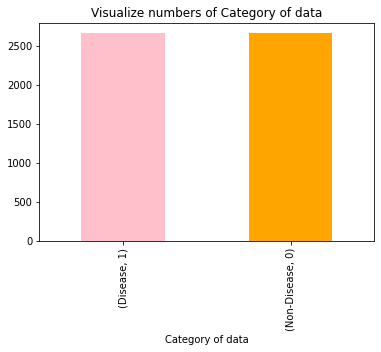

In [ ]:
import matplotlib.pyplot as plt
df_balanced.groupby('Category').Label.value_counts().plot(kind = "bar", color = ["pink", "orange", "red", "yellow", "blue"])
plt.xlabel("Category of data")
plt.title("Visualize numbers of Category of data")
plt.show()

In [ ]:
df_balanced.sample(5)

,Unnamed: 0,Sentence,Category,Label
731,731,"Ring chromosome 20, ring-shaped chromosome 20 ...",Disease,1
701,701,32527 31410Chondrodysplasia punctata is a clin...,Disease,1
2732,2732,Phenylketonuria (PKU) is an inborn error of me...,Disease,1
3660,3660,XYY syndrome is a genetic condition in which a...,Disease,1
3032,3032,Alveolar rhabdomyosarcoma is a type of rhabdom...,Disease,1


In [ ]:
del df_balanced['Unnamed: 0']

In [ ]:
df_balanced['Sentence'] = df_balanced['Sentence'].astype(str)

In [ ]:
df_balanced.sample(5)

,Sentence,Category,Label
717,"Choroid plexus papilloma, also known as papill...",Disease,1
536,A brain tumor or intracranial neoplasm occurs ...,Disease,1
1246,"1CZS, 1CZT, 1CZV, 1FV4, 1Y61, 3P6Z, 3P70, 3S9C...",Disease,1
4385,Organogermanium compounds are organometallic c...,Non-Disease,0
2284,Molybdenum cofactor deficiency is a rare human...,Disease,1


In [ ]:
df_balanced.dtypes

Sentence    object
Category    object
Label        int64
dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_balanced['Sentence'],df_balanced['Label'], stratify=df_balanced['Label'])

# **The preprocessing model**
Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for BERT.

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")

# **Using the BERT model**
The BERT encoder model can be loaded from TF hub. Further, we can  create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

In [ ]:
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_type_ids': ( 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'pooled_output': (N 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [ ]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
 loss='binary_crossentropy',
 metrics=METRICS)

In [ ]:
history = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
125/125 [==============================] - 57s 365ms/step - loss: 0.4645 - accuracy: 0.8368 - precision: 0.8141 - recall: 0.8729
Epoch 2/10
125/125 [==============================] - 48s 388ms/step - loss: 0.2487 - accuracy: 0.9535 - precision: 0.9556 - recall: 0.9513
Epoch 3/10
125/125 [==============================] - 50s 400ms/step - loss: 0.1792 - accuracy: 0.9661 - precision: 0.9654 - recall: 0.9669
Epoch 4/10
125/125 [==============================] - 53s 420ms/step - loss: 0.1418 - accuracy: 0.9704 - precision: 0.9718 - recall: 0.9689
Epoch 5/10
125/125 [==============================] - 49s 389ms/step - loss: 0.1239 - accuracy: 0.9721 - precision: 0.9686 - recall: 0.9759
Epoch 6/10
125/125 [==============================] - 50s 396ms/step - loss: 0.1088 - accuracy: 0.9761 - precision: 0.9764 - recall: 0.9759
Epoch 7/10
125/125 [==============================] - 49s 395ms/step - loss: 0.1014 - accuracy: 0.9754 - precision: 0.9768 - recall: 0.9739
Epoch 8/10
125/125 [

In [ ]:
history = history.history
history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall'])

In [ ]:
print('Accuracy: {acc}, Precision: {precision}, Recall: {recall}'.format(
        acc=history['accuracy'][-1], precision=history['precision'][-1], recall=history['recall'][-1]))

Accuracy: 0.9796584844589233, Precision: 0.9808660745620728, Recall: 0.9784027934074402


In [ ]:
# Save model.
model.save('/content/gdrive/MyDrive/Disease_classification_bert1.h5')

In [ ]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

In [ ]:
y_predicted = np.where(y_predicted > 0.5, 1, 0)

In [ ]:
print(y_predicted)

[1 0 0 ... 0 0 0]


In [ ]:
print(y_test)

1272    1
3560    0
6490    0
5634    0
4263    0
       ..
5989    0
4487    0
5206    0
4097    0
3649    0
Name: Label, Length: 1328, dtype: int64


In [ ]:
# Test accuracy
print("The test accuracy is: ")
print(accuracy_score(y_test, y_predicted))

The test accuracy is: 
0.9774096385542169


In [ ]:
# Classification report
print("Classification report")
print(classification_report(y_test, y_predicted))

Classification report
              precision    recall  f1-score   support

           0       0.97      0.98      0.98       664
           1       0.98      0.97      0.98       664

    accuracy                           0.98      1328
   macro avg       0.98      0.98      0.98      1328
weighted avg       0.98      0.98      0.98      1328



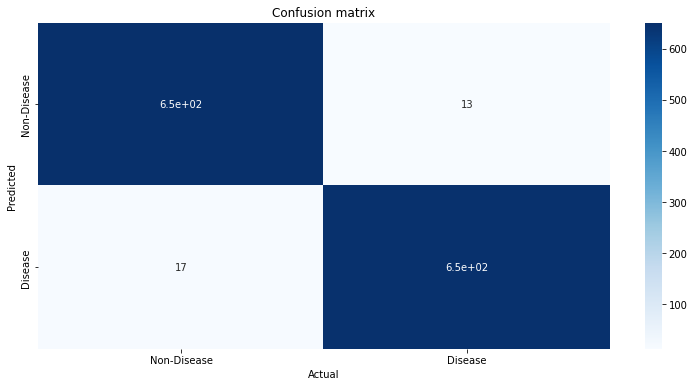

In [ ]:
aux_df = df_balanced[['Category', 'Label']].drop_duplicates().sort_values('Label')
conf_matrix = confusion_matrix(y_test, y_predicted)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['Category'].values, 
            yticklabels=aux_df['Category'].values,
            cmap="Blues")
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

**Test classifier predictions on new data**

In [ ]:
sample_dataset1 = [
  'Cancer is a group of diseases involving abnormal cell growth with the potential to invade or spread to other parts of the body. These contrast with benign tumors, which do not spread. Possible signs and symptoms include a lump, abnormal bleeding, prolonged cough, unexplained weight loss, and a change in bowel movements. While these symptoms may indicate cancer, they can also have other causes. Over 100 types of cancers affect humans.',
  'The Central Board of Secondary Education (CBSE) is a national level board of education in India for public and private schools, controlled and managed by the Government of India.'
]

In [ ]:
sample_pred1 = model.predict(sample_dataset1)
print(sample_pred1)

[[0.96019894]
 [0.04226561]]


**To check if Classifier misclassifies drug article(Penicillin) as disease article.**

In [ ]:
sample_dataset2 = [
    '''Penicillins (P, PCN or PEN) are a group of antibiotics originally obtained from Penicillium moulds, 
    principally P. chrysogenum and P. rubens. Most penicillins in clinical use are synthesised by P. 
    chrysogenum using deep tank fermentation[2] and then purified.[3][4] A number of natural penicillins 
    have been discovered, but only two purified compounds are in clinical use: penicillin G (intramuscular 
    or intravenous use) and penicillin V (given by mouth). Penicillins were among the first medications 
    to be effective against many bacterial infections caused by staphylococci and streptococci. They are 
    members of the β-lactam antibiotics.[5] They are still widely used today for different bacterial 
    infections, though many types of bacteria have developed resistance following extensive use.
    About 10% of people report that they are allergic to penicillin; however, up to 90% of this group may 
    not actually be allergic.[6] Serious allergies only occur in about 0.03%.[for whom?][6] Research 
    highlights the importance of both doctors and patients discussing recorded penicillin allergies.[7][8] 
    Those who are allergic to penicillin are most often given cephalosporin C (another β-lactam antibiotic)
    because there is only 10% crossover in allergy between the penicillins and cephalosporins.[5]
    Penicillin was discovered in 1928 by Scottish scientist Alexander Fleming as a crude extract of 
    P. rubens.[9] Fleming's student Cecil George Paine was the first to successfully use penicillin to 
    treat eye infection (ophthalmia neonatorum) in 1930. The purified compound (penicillin F) was isolated 
    in 1940 by a research team led by Howard Florey and Ernst Boris Chain at the University of Oxford. 
    Fleming first used the purified penicillin to treat streptococcal meningitis in 1942.[10] For the 
    discovery, Fleming shared the 1945 Nobel Prize in Physiology or Medicine with Florey and Chain.'''               
]

In [ ]:
sample_pred2 = model.predict(sample_dataset2)
print(sample_pred2)

[[0.92531836]]
